recommender.py - класс с самим рекомендатором, там fit, predict и всякие set'ы<br>
utils.py - метрики и вспомогательные функции загрузки данных<br>
model.py - сама нейронка<br>
loader.py - загрузчик датасета для нейронки<br>
Иходные данные https://www.kaggle.com/c/instacart-market-basket-analysis/data<br>
analysis - всякие графики и статистика<br>
Там 206 000 покупателей, чтобы было быстрее берём 10 000 случайных

In [1]:
# Чтобы jupyter видел .py файлы в текущей папке
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parents[0] / "py"))

In [2]:
import pickle
import pandas as pd
import numpy as np
import random
from random import randrange
from recommender import Recommender
from utils import mapk, hitk, split, load_data

In [4]:
# Возьмём 10 000 случайных пользователей.

orders = pd.read_csv('orders.csv')[['user_id', 'order_id', 'order_number']]
users_subsample = random.sample(orders['user_id'].unique().tolist(), 10000)
with open('saves/users_subsample.pickle', 'wb') as out:
    pickle.dump(users_subsample, out)

orders = orders[orders['user_id'].isin(users_subsample)]
split(orders)
train_df, validation_df, test_df, user_enum, product_enum = load_data()

In [3]:
from tqdm.notebook import tqdm

mapk_val, mapk_train, hitk_val, hitk_train = [], [], [], []

# Для обучения для каждого купленного пользователем продукта выбираем несколько продуктов, которые он не покупал
# Оптимально на один купленный 3 негативных
for neg in tqdm([2,3,4,5]):
    # Если обучаяем с нуля
    recommender = Recommender(train_df, validation_df, test_df, neg_num=neg)
    recommender.train_data.to_csv('saves/train_data_for_model-{}_neg.csv'.format(neg), index=False)
    recommender.val_data.to_csv('saves/val_data_for_model.csv', index=False)
    recommender.test_data.to_csv('saves/test_data_for_model.csv', index=False)
    recommender.set_components_number(5) # число компонент в эмбэдинге
    recommender.fit('saves/model-5-{}neg.pickle'.format(neg), epochs=10)

    # Если уже обучили и сохранили данные и модели, то просто загружаем их
#     recommender = Recommender(neg_num=neg)
#     recommender.set_components_number(5) # число компонент в эмбэдинге
#     recommender.set_data_for_model('saves/train_data_for_model-{}_neg.csv'.format(neg), 'saves/val_data_for_model.csv', 'saves/test_data_for_model.csv')
# #     recommender.set_model('saves/model-5-{}neg.pickle'.format(neg))
#     recommender.fit('saves/model-5-{}neg.pickle'.format(neg), epochs=10)
    
    val_dict = recommender.val_data.groupby('user_id')['product_id'].apply(list).to_dict()
    actual_val_dict = recommender.val_data[recommender.val_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()
    train_dict = recommender.train_data.groupby('user_id')['product_id'].apply(list).to_dict()
    actual_train_dict = recommender.train_data[recommender.train_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

    # В валидационной выборке для каждого покупателя на один купленный продукт есть 10 некупленных
    # Предсказываем для продуктов вероятность, что пользователь их купит, сортируем
    # map@k учитывает место, на котором находится продукт в отсортированных предсказаниях, это метрика ранжирования
    # p@k не учитывает место в отсортированном списке где стоят нужные продукты, проверяем только их наличие
    preds = []
    actuals = []
    for user, items in val_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_val_dict[user]]
    mapk_val += [mapk(actuals, preds)]
    hitk_val += [hitk(actuals, preds)]
    
    preds = []
    actuals = []
    for user, items in train_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_train_dict[user]]
    mapk_train += [mapk(actuals, preds)]
    hitk_train += [hitk(actuals, preds)]

  0%|          | 0/6 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

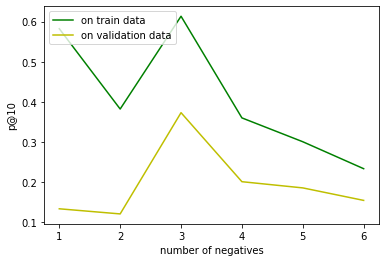

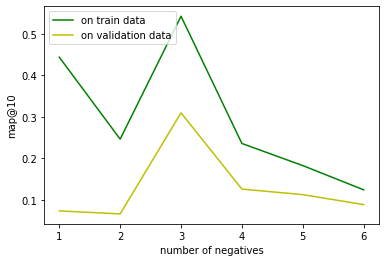

In [5]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([2, 3, 4, 5], hitk_train, label='on train data', c='g'),
plt.plot([2, 3, 4, 5], hitk_val, label='on validation data', c='y')
plt.xlabel('number of negatives')
plt.ylabel('p@10')
plt.legend(loc='upper left')
plt.show()
plt.figure(2)
plt.plot([2, 3, 4, 5], mapk_train, label='on train data', c='g'),
plt.plot([2, 3, 4, 5], mapk_val, label='on validation data', c='y')
plt.xlabel('number of negatives')
plt.ylabel('map@10')
plt.legend(loc='upper left')
plt.show()

In [16]:
from tqdm.notebook import tqdm

optimal_neg_num = 3
recommender = Recommender(neg_num=optimal_neg_num)
recommender.set_data_for_model('saves/train_data_for_model-{}_neg.csv'.format(optimal_neg_num), 'saves/val_data_for_model.csv', 'saves/test_data_for_model.csv')

val_dict = recommender.val_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_val_dict = recommender.val_data[recommender.val_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()
train_dict = recommender.train_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_train_dict = recommender.train_data[recommender.train_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

mapk_val, mapk_train, hitk_val, hitk_train = [], [], [], []

for comp in tqdm([3, 4, 5, 6, 7, 8, 9, 10]):
    recommender.set_components_number(comp)
    recommender.fit('saves/model-{}-{}neg.pickle'.format(comp, optimal_neg_num), epochs=10)
#     recommender.set_model('saves/model-{}-{}neg.pickle'.format(comp, optimal_neg_num))
    
    preds = []
    actuals = []
    for user, items in val_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_val_dict[user]]
    mapk_val += [mapk(actuals, preds)]
    hitk_val += [hitk(actuals, preds)]
    
    preds = []
    actuals = []
    for user, items in train_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_train_dict[user]]
    mapk_train += [mapk(actuals, preds)]
    hitk_train += [hitk(actuals, preds)]

  0%|          | 0/8 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 30.0 K
1 | item_embedding | Embedding | 106 K 
2 | fc1            | Linear    | 105   
3 | fc2            | Linear    | 144   
4 | fc3            | Linear    | 30    
5 | output         | Linear    | 4     
---------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.549     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 40.0 K
1 | item_embedding | Embedding | 142 K 
2 | fc1            | Linear    | 180   
3 | fc2            | Linear    | 252   
4 | fc3            | Linear    | 52    
5 | output         | Linear    | 5     
---------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.732     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 275   
3 | fc2            | Linear    | 390   
4 | fc3            | Linear    | 80    
5 | output         | Linear    | 6     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.916     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 60.0 K
1 | item_embedding | Embedding | 213 K 
2 | fc1            | Linear    | 390   
3 | fc2            | Linear    | 558   
4 | fc3            | Linear    | 114   
5 | output         | Linear    | 7     
---------------------------------------------
274 K     Trainable params
0         Non-trainable params
274 K     Total params
1.100     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 70.0 K
1 | item_embedding | Embedding | 249 K 
2 | fc1            | Linear    | 525   
3 | fc2            | Linear    | 756   
4 | fc3            | Linear    | 154   
5 | output         | Linear    | 8     
---------------------------------------------
320 K     Trainable params
0         Non-trainable params
320 K     Total params
1.284     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 80.0 K
1 | item_embedding | Embedding | 285 K 
2 | fc1            | Linear    | 680   
3 | fc2            | Linear    | 984   
4 | fc3            | Linear    | 200   
5 | output         | Linear    | 9     
---------------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.468     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 90.0 K
1 | item_embedding | Embedding | 320 K 
2 | fc1            | Linear    | 855   
3 | fc2            | Linear    | 1.2 K 
4 | fc3            | Linear    | 252   
5 | output         | Linear    | 10    
---------------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.653     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 100 K 
1 | item_embedding | Embedding | 356 K 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 1.5 K 
4 | fc3            | Linear    | 310   
5 | output         | Linear    | 11    
---------------------------------------------
459 K     Trainable params
0         Non-trainable params
459 K     Total params
1.837     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

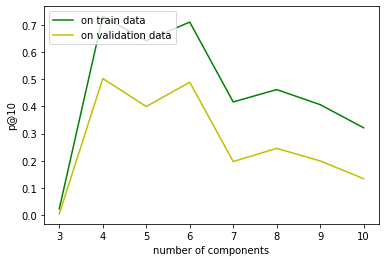

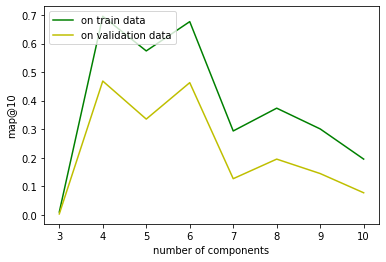

In [17]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([3, 4, 5, 6, 7, 8, 9, 10], hitk_train, label='on train data', c='g'),
plt.plot([3, 4, 5, 6, 7, 8, 9, 10], hitk_val, label='on validation data', c='y')
plt.xlabel('number of components')
plt.ylabel('p@10')
plt.legend(loc='upper left')
plt.show()
plt.figure(2)
plt.plot([3, 4, 5, 6, 7, 8, 9, 10], mapk_train, label='on train data', c='g'),
plt.plot([3, 4, 5, 6, 7, 8, 9, 10], mapk_val, label='on validation data', c='y')
plt.xlabel('number of components')
plt.ylabel('map@10')
plt.legend(loc='upper left')
plt.show()

In [3]:
# orders = pd.read_csv('orders.csv')[['user_id', 'order_id', 'order_number']]
# users_subsample = random.sample(orders['user_id'].unique().tolist(), 10000)
# orders = orders[orders['user_id'].isin(users_subsample)]
# split(orders)

optimal_neg_num = 3
optimal_comp_num = 4
train_df, validation_df, test_df, user_enum, product_enum = load_data()
recommender = Recommender(neg_num=optimal_neg_num)
recommender.set_components_number(optimal_comp_num)
recommender.set_data_for_model('saves/train_data_for_model-{}_neg.csv'.format(optimal_neg_num), 'saves/val_data_for_model.csv', 'saves/test_data_for_model.csv')
# recommender.fit('saves/model.pickle', epochs=10)
recommender.set_model('saves/model.pickle')

test_dict = recommender.test_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_test_dict = recommender.test_data[recommender.test_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

preds = []
actuals = []
for user, items in test_dict.items():
    res = recommender.predict_for_user(user, items).tolist()
    preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
    actuals += [actual_test_dict[user]]
mapk_test = mapk(actuals, preds)
hitk_test = hitk(actuals, preds)

print('3 negative examples, 4 components in embedding, 10 epochs:')
print('mAP@10 {}'.format(mapk_test))
print('mP@10 {}'.format(hitk_test))

3 negative examples, 4 components in embedding, 10 epochs:
mAP@10 0.4973727993405533
mP@10 0.5410881801125703


In [4]:
user_id = 10
user_data = recommender.test_data[recommender.test_data['user_id'] == user_id]
actual = user_data[user_data['bought'] != 0]['product_id'].to_list()
to_predict = user_data['product_id'].to_list()
res = recommender.predict_for_user(user_id, to_predict).tolist()
predicted = [x for _, x in sorted(zip(res, to_predict), reverse=True)][:10]
inv_product_enum = {v: k for k, v in product_enum.items()}
predicted = [inv_product_enum[i] for i in predicted]
actual = [inv_product_enum[i] for i in actual]

hits = np.intersect1d(predicted, actual)
products = pd.read_csv('products.csv')
predicted = list(products[products['product_id'].isin(predicted)]['product_name'])
actual = list(products[products['product_id'].isin(actual)]['product_name'])
hits = list(products[products['product_id'].isin(hits)]['product_name'])
print('Recommendations:')
print(*predicted, sep='\n')
print('\nActual:')
print(*actual, sep='\n')
print('\nHits:')
print(*hits, sep='\n')

Recommendations:
Roasted Mushroom Pizza
Cage Free Large White Eggs
Classico Virgin Olive Oil Bruschnettini
Classic Almond Butter All Natural
Bread, Natural Fitness
Organic Vanilla Bean Ice Cream
Half & Half
Organic White Cheddar Popcorn
Greek Feta Cheese
Large Lemon

Actual:
Caramel Sauce
Organic Milk
Cornichons Gherkins
Vanilla Bean Ice Cream
Organic Unsalted Butter
Roasted Mushroom Pizza
Organic Salted Individually Wrapped Quarters Butter
Cage Free Large White Eggs
Organic Madagascar Vanilla Ice Cream
Lager Beer
Bread, Natural Fitness
Organic Curry Powder
Organic Vanilla Bean Ice Cream
Half & Half
Bolani Spinach Filled Flatbread
Sweet Batard
Organic Large Grade AA Brown Eggs
Double Fiber Whole Grain Sliced English Muffins
Frozen Dark Sweet Pitted Cherries
Broccoli Florets
Frozen Blueberries
Plain Pre-Sliced Bagels
Large Lemon

Hits:
Roasted Mushroom Pizza
Cage Free Large White Eggs
Bread, Natural Fitness
Organic Vanilla Bean Ice Cream
Half & Half
Large Lemon


In [4]:
recommender.predict([1, 1001], [3, 15])

[[0.2670181691646576, 0.27601850032806396],
 [0.19860729575157166, 0.2309517115354538]]

In [5]:
recommender.predict_for_user(0, [3, 2, 0, 1])

[0.23553025722503662,
 0.004860855173319578,
 0.23494558036327362,
 0.013939998112618923]